In [117]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras

from keras.models import Model
from keras.layers import Input, Layer, Activation, Dense, Flatten, Dropout, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras import backend as K
from sklearn.model_selection import train_test_split

import os
from PIL import Image
from matplotlib.pyplot import imshow
from random import randrange

In [17]:
# Load data.
data = []
paths = []
for r, d, f in os.walk(r"D:\Downloads\pokemon-mugshots-from-super-mystery-dungeon\smd"):
    for file in f:
        if '.png' in file:
            paths.append(os.path.join(r, file))
            
for path in paths:
    img = Image.open(path)
    x = np.array(img)
    x = x[...,:3]
    if(x.shape == (64,64,3)):
        data.append(x)

src = np.array(data)
src = src.reshape(len(data),64,64,3)


#splitting data into train and test sets
x_train,x_test,y_train,y_test = train_test_split(src, src, test_size=0.2, shuffle=True, random_state=69)

# Normalize data.
x_test = x_test / np.max(x_train)
x_train = x_train / np.max(x_train)

In [285]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))
        
        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(w, encoding_indices, validate_indices=False)

In [286]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance
        
        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss
        
        return recon_loss + loss #* beta
    return vq_vae_loss

In [287]:

# Hyper Parameters.
epochs = 250 # MAX
batch_size = 500
validation_split = 0.2

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 128 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2,
                                    patience=15, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [288]:
# Encoder
input_img = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_img)
#x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)

# VQVAELayer.
enc = Conv2D(embedding_dim, kernel_size=(1, 1), strides=(1, 1), name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv2DTranspose(64, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = Conv2DTranspose(3, (3, 3))(x)

# Autoencoder.
vqvae = Model(input_img, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()
# this model maps an input to its encoded representation
encoder = Model(input_img, enc)
encoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 12, 12, 64)        369

In [333]:
history = vqvae.fit(x_train, x_train,batch_size=batch_size, epochs=epochs,validation_data=(x_test, x_test))

Train on 3904 samples, validate on 977 samples
Epoch 1/250
3904/3904 [==============================] - 2s 450us/step - loss: 0.8759 - val_loss: 0.8832
Epoch 2/250
3904/3904 [==============================] - 2s 424us/step - loss: 0.8794 - val_loss: 0.8813
Epoch 3/250
3904/3904 [==============================] - 2s 424us/step - loss: 0.8761 - val_loss: 0.8821
Epoch 4/250
3904/3904 [==============================] - 2s 470us/step - loss: 0.8770 - val_loss: 0.8788
Epoch 5/250
3904/3904 [==============================] - 2s 467us/step - loss: 0.8728 - val_loss: 0.8791
Epoch 6/250
3904/3904 [==============================] - 2s 428us/step - loss: 0.8780 - val_loss: 0.8809
Epoch 7/250
3904/3904 [==============================] - 2s 441us/step - loss: 0.8751 - val_loss: 0.8838
Epoch 8/250
3904/3904 [==============================] - 2s 460us/step - loss: 0.8784 - val_loss: 0.8797
Epoch 9/250
3904/3904 [==============================] - 2s 434us/step - loss: 0.8733 - val_loss: 0.8793
Epoch 10

Epoch 78/250
3904/3904 [==============================] - 2s 432us/step - loss: 0.8559 - val_loss: 0.8559
Epoch 79/250
3904/3904 [==============================] - 2s 433us/step - loss: 0.8508 - val_loss: 0.8559
Epoch 80/250
3904/3904 [==============================] - 2s 492us/step - loss: 0.8502 - val_loss: 0.8543
Epoch 81/250
3904/3904 [==============================] - 2s 481us/step - loss: 0.8509 - val_loss: 0.8521
Epoch 82/250
3904/3904 [==============================] - 2s 493us/step - loss: 0.8495 - val_loss: 0.8511
Epoch 83/250
3904/3904 [==============================] - 2s 446us/step - loss: 0.8494 - val_loss: 0.8543
Epoch 84/250
3904/3904 [==============================] - 2s 450us/step - loss: 0.8491 - val_loss: 0.8526
Epoch 85/250
3904/3904 [==============================] - 2s 444us/step - loss: 0.8489 - val_loss: 0.8648
Epoch 86/250
3904/3904 [==============================] - 2s 432us/step - loss: 0.8532 - val_loss: 0.8521
Epoch 87/250
3904/3904 [======================

Epoch 155/250
3904/3904 [==============================] - 2s 454us/step - loss: 0.8266 - val_loss: 0.8303
Epoch 156/250
3904/3904 [==============================] - 2s 445us/step - loss: 0.8276 - val_loss: 0.8376
Epoch 157/250
3904/3904 [==============================] - 2s 433us/step - loss: 0.8265 - val_loss: 0.8318
Epoch 158/250
3904/3904 [==============================] - 2s 438us/step - loss: 0.8280 - val_loss: 0.8246
Epoch 159/250
3904/3904 [==============================] - 2s 422us/step - loss: 0.8186 - val_loss: 0.8360
Epoch 160/250
3904/3904 [==============================] - 2s 421us/step - loss: 0.8263 - val_loss: 0.8273
Epoch 161/250
3904/3904 [==============================] - 2s 421us/step - loss: 0.8181 - val_loss: 0.8224
Epoch 162/250
3904/3904 [==============================] - 2s 430us/step - loss: 0.8221 - val_loss: 0.8237
Epoch 163/250
3904/3904 [==============================] - 2s 426us/step - loss: 0.8229 - val_loss: 0.8493
Epoch 164/250
3904/3904 [============

3904/3904 [==============================] - 2s 448us/step - loss: 0.8102 - val_loss: 0.8204
Epoch 232/250
3904/3904 [==============================] - 2s 463us/step - loss: 0.8089 - val_loss: 0.8127
Epoch 233/250
3904/3904 [==============================] - 2s 430us/step - loss: 0.8115 - val_loss: 0.8428
Epoch 234/250
3904/3904 [==============================] - 2s 430us/step - loss: 0.8177 - val_loss: 0.8140
Epoch 235/250
3904/3904 [==============================] - 2s 430us/step - loss: 0.8103 - val_loss: 0.8114
Epoch 236/250
3904/3904 [==============================] - 2s 430us/step - loss: 0.8086 - val_loss: 0.8123
Epoch 237/250
3904/3904 [==============================] - 2s 428us/step - loss: 0.8087 - val_loss: 0.8155
Epoch 238/250
3904/3904 [==============================] - 2s 436us/step - loss: 0.8059 - val_loss: 0.8153
Epoch 239/250
3904/3904 [==============================] - 2s 453us/step - loss: 0.8067 - val_loss: 0.8117
Epoch 240/250
3904/3904 [==========================

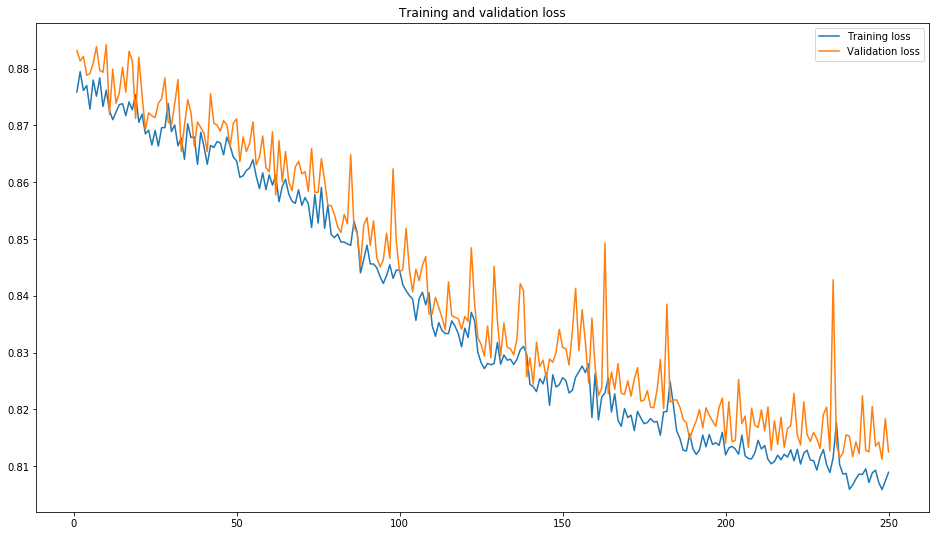

In [334]:
# Plot training results.
loss = history.history['loss'] # Training loss.
val_loss = history.history['val_loss'] # Validation loss.
num_epochs = range(1, 1 + len(history.history['loss'])) # Number of training epochs.

plt.figure(figsize=(16,9))
plt.plot(num_epochs, loss, label='Training loss') # Plot training loss.
plt.plot(num_epochs, val_loss, label='Validation loss') # Plot validation loss.

plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


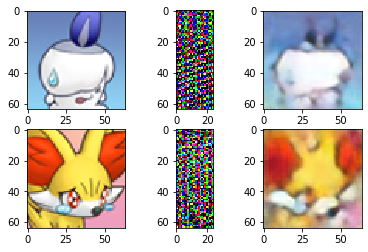

In [372]:
size = 2
f, axarr = plt.subplots(size,3)
for i in range(size):
    index = randrange(len(x_train))
    sample = x_train[index]
    sample = sample.reshape(1,64,64,3)
    image = vqvae.predict(sample).reshape(64,64,3)*255
    image = image.astype(int)
    en = encoder.predict(sample)
    en = en.reshape(64,24,3)
    axarr[i,0].imshow(x_train[index])
    axarr[i,1].imshow(en)
    axarr[i,2].imshow(image)

In [342]:
vqvae.save('VQVAE1.h5')
encoder.save('encoder.h5')